In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts


STEP 1 : Exploring Stock Market Dynamics: Sector-Based Data Collection and Clustering Analysis

In [4]:
#CA VA APPARAITRE EN PREMIER POUR CHOSIR UN SECTOR
sectors = [
    'Communication_Services', 
    'Energy', 
    'financials', 
    'Health_Care', 
    'Industrials', 
    'Information_Technology', 
    'Real_Estate'
]

#function 1 : gives the data and their selected stocks of each stock (it wont be in the front it will be just the data provider of the other functions bellow) 
def load_sector_data(sector):
    """
    Function to load data for a specific sector.
    
    :param sector: A string representing the sector to load data for.
    :return: A tuple where the first element is a DataFrame with the selected stocks data, and the second element is a DataFrame with the price data.
    """
    # Load the selected stocks financials and sentiment data from the CSV file
    selected_stocks_df = pd.read_csv(f'selected_stocks_{sector}.csv', index_col='symbol')

    # Load the price data
    price_data = pd.read_csv(f'hist adjust close {sector}.csv', index_col='Date', parse_dates=True)
    
    return selected_stocks_df, price_data


#function 2 : gives the stocks of each cluster of the selected sector (it will be in the front in a table format to show the stocks of each cluster in each sector)

def cluster_stocks(sector):
    """
    Cluster the stocks of a specific sector based on their adjusted correlation.
    
    :param sector: A string representing the sector to cluster stocks for.
    """
    # Load the data for the sector
    selected_stocks_df, price_data = load_sector_data(sector)

    # Calculate returns and drop NA values
    price_returns = price_data.pct_change().dropna()

    # Calculate the correlation matrix
    correlation_matrix = price_returns.corr()

    # Adjust the correlation matrix here as needed before clustering

    # Cluster the stocks based on the correlation matrix using the k-means algorithm
    n_clusters = 4  # Set the number of clusters
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(correlation_matrix)

    # Create a dictionary mapping stock symbols to cluster labels
    symbol_cluster_dict = {symbol: cluster_labels[i] for i, symbol in enumerate(price_returns.columns)}
    
    # Create a dictionary to store the tickers for each cluster
    cluster_dict = {}
    for i in range(n_clusters):
        cluster_dict[f'Cluster {i+1}'] = price_returns.columns[cluster_labels==i].tolist()
    return cluster_dict


#function 3 : gives the visualisation of the kmeans algo of stocks of the selected sector (it will be in the front in visualisation format)

def visualize_clusters(sector):
    """
    Cluster the stocks of a specific sector and visualize the clusters.
    
    :param sector: A string representing the sector to cluster stocks for.
    """
    # Get the clusters and the price returns for the sector
    clusters_dict = cluster_stocks(sector)

    price_returns=load_sector_data(sector)[1].pct_change().dropna()
    # Get the number of clusters
    n_clusters = len(clusters_dict)

    # Visualize the clustering results
    fig, ax = plt.subplots(figsize=(18, 12))

    # Set point size and color based on cluster labels
    point_size = 150
    colors = ['red', 'blue', 'green', 'orange']
    for i, cluster_label in enumerate(clusters_dict.keys()):
        cluster_stocks_list = clusters_dict[cluster_label]
        ax.scatter(price_returns[cluster_stocks_list].mean(), price_returns[cluster_stocks_list].std(), s=point_size, color=colors[i], alpha=0.7, label=cluster_label)

        # Add stock labels to each point
        for symbol in cluster_stocks_list:
            ax.annotate(symbol, xy=(price_returns[symbol].mean(), price_returns[symbol].std()), 
                        xytext=(5,-5), textcoords='offset points', fontsize=12)

    ax.set_xlabel('Expected Returns', fontsize=16)
    ax.set_ylabel('Risk', fontsize=16)
    ax.set_title(f'{n_clusters}-Cluster Solution for {sector} Sector', fontsize=20)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(fontsize=14)
    plt.show()


#function 4 : saves the csv files of the clusters generated of the kmeans(it will be usefull for the next part of the trading process the results bcz we are gonna call those csv to backtest the strategies)

def save_clusters_to_csv(sector):
    """
    Cluster the stocks of a specific sector and save each cluster to a separate CSV file.
    
    :param sector: A string representing the sector to cluster stocks for.
    """
    # Get the clusters for the sector
    clusters_dict = cluster_stocks(sector)

    # Save each cluster to a CSV file
    for cluster_label, stocks_list in clusters_dict.items():
        # Save tickers to CSV
        with open(f'{sector}_{cluster_label}.csv', 'w') as f:
            f.write(','.join(stocks_list))

THE USE OF FUNCTIONS OF STEP 1

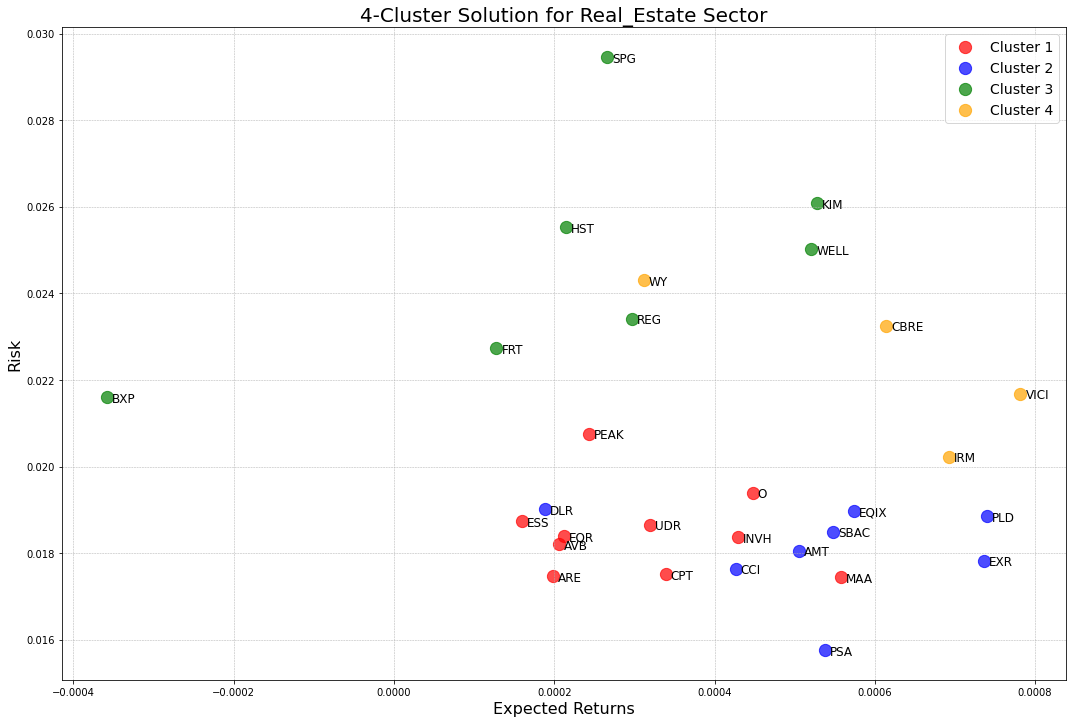

In [7]:

#I WORKED HERE WITH THE Real_Estate AS AN EXEMPLE SINON IL VA PRENDRE VALEUR DIAL SECTOR GIVEN BY THE USER
sector = 'Real_Estate'


"""
the use of function 1
"""

# Load the selected stocks financials and sentiment data from the CSV file
selected_stocks_df = load_sector_data(sector)[0] 

price_data = load_sector_data(sector)[1] 



"""
the use of function 2
"""
# Run the clustering process for the 'Energy' sector
cluster_stocks(sector)



"""
the use of function 3
"""

visualize_clusters(sector)



"""
the use of function 4
"""

save_clusters_to_csv(sector)



STEP 2 : Advanced Trading Analysis and Simulation Toolkit - Z-score and Trade History

In [5]:
#CA VA APPARAITRE GRIS 
sectors = [
    'Communication_Services', 
    'Energy', 
    'financials', 
    'Health_Care', 
    'Industrials', 
    'Information_Technology', 
    'Real_Estate'
]


#CA VA APPARAITRE POUR CHOISIR UNE CLUSTER (LE TYPE DOIT ETRE INT BCZ THE FUNCTION analyze_cluster_pairs INPUT IS INT)
cluster_num = [
    1, 
    2, 
    3, 
    4
]


#CA VA APPARAITRE POUR CHOISIR VALEUR DE SIGNIFANCE LEVEL OF COINTEGRATION AND MEAN REVERSION (c'est mieux quil soit une valeur num au lieu de ces deux choix)
significance_level_coint = [
    0.05, 
    0.1
]
significance_level_mean_revert= [
    0.05, 
    0.1
]


#functions predefined here in order to use them in the following functions

def is_cointegrated(df, stock1, stock2, significance_level=0.1):
    # Filter rows with missing or infinite values for the two stocks
    filtered_df = df[[stock1, stock2]].dropna()
    y = filtered_df[stock1]
    x = filtered_df[stock2]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    residuals = model.resid
    adf_result = ts.adfuller(residuals)
    p_value = adf_result[1]
    return p_value < significance_level

def calculate_correlation(df, stock1, stock2):
    return df[[stock1, stock2]].pct_change().corr().iloc[0, 1]

def calculate_residuals(df, stock1, stock2):
    y = df[stock1].dropna()
    x = df[stock2].dropna()
    common_index = y.index.intersection(x.index)  # Ensure we only use rows where both x and y are not NaN
    y = y.loc[common_index]
    x = x.loc[common_index]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    residuals = model.resid
    return residuals

def is_mean_reverting(residuals, significance_level=0.1):
    adf_result = ts.adfuller(residuals, maxlag=0)
    p_value = adf_result[1]
    return p_value < significance_level

def calculate_z_score_spread(df, stock1, stock2):
    spread = df[stock1] - df[stock2]
    z_score_spread = (spread - spread.mean()) / spread.std()
    return z_score_spread


#function 1 : gives the appropriate pairs selected based on cointegration and mean reversion  

def analyze_cluster_pairs(sector, cluster_num, significance_level_coint=0.1, significance_level_mean_revert=0.1):
    """
    Function to analyze stock pairs in a cluster for a given sector.
    
    :param sector: A string representing the sector to analyze.
    :param cluster_num: An integer representing the cluster number to analyze.
    :param significance_level_coint: A float representing the significance level for cointegration.
    :param significance_level_mean_revert: A float representing the significance level for mean reversion.
    :return: A list of selected pairs for mean reversion trading.
    """
    # Load sector data
    selected_stocks_df, price_data = load_sector_data(sector)

    # Define the size of the train set
    train_size = int(len(price_data) * 0.8)

    # Split the data
    train = price_data[:train_size]
    test = price_data[train_size:]

    # Cluster stocks
    clusters_dict = cluster_stocks(sector)

    # Extract the specified cluster
    cluster = clusters_dict[f'Cluster {cluster_num}']

    selected_pairs = []

    # Analyze the cluster
    n = len(cluster)
    for i in range(n):
        for j in range(i + 1, n):
            stock1 = cluster[i]
            stock2 = cluster[j]
            #correlation = calculate_correlation(train, stock1, stock2)
            cointegrated = is_cointegrated(train, stock1, stock2, significance_level=significance_level_coint)
            if cointegrated:
                residuals = calculate_residuals(train, stock1, stock2)
                mean_reverting = is_mean_reverting(residuals, significance_level=significance_level_mean_revert)
                if mean_reverting:
                    selected_pairs.append((stock1, stock2))
    
    return selected_pairs 

#ce resultat doit etre dans le doropdown de pairs pour choisir quelle pair a choisir 
#(tu peux acceder a ces pairs(le symbole seulement) par cette commandes 'selected_pairs1[i]')
    
    
    
#function 2:  le PLOT de zscore and the thresholds of the chosen pairs in the previous function(the pair argument will be the  analyze_cluster_pairs(sector, 2)[0]) + trade history dataframe

def plot_and_simulate_trading(pair, sector, cluster_num, upper_threshold=1, lower_threshold=-1, initial_cash=10000):
    """
    Function to plot trading signals for a given pair of stocks and simulate trading based on the signals.
    
    :param pair: A tuple representing the pair of stocks.
    :param sector: A string representing the sector to analyze.
    :param cluster_num: An integer representing the cluster number to analyze.
    :param upper_threshold: A float representing the upper threshold for the z-score spread.
    :param lower_threshold: A float representing the lower threshold for the z-score spread.
    :param initial_cash: A float representing the initial cash for trading.
    :return: A DataFrame containing the trade history.
    """
    # Load sector data
    selected_stocks_df, price_data = load_sector_data(sector)

    # Define the size of the train set
    train_size = int(len(price_data) * 0.8)

    # Split the data
    train = price_data[:train_size]
    test = price_data[train_size:]

    # The selected pair of stocks
    stock1, stock2 = pair

    # Calculate the z-score spread
    z_score_spread = calculate_z_score_spread(test, stock1, stock2)

    # Identify the buy and sell signals
    buy_signals = z_score_spread < lower_threshold
    sell_signals = z_score_spread > upper_threshold

    # Plot trading signals
    plt.figure(figsize=(30, 14))
    plt.plot(z_score_spread, label='Z-score Spread', linewidth=2)
    plt.plot(z_score_spread[buy_signals].index, z_score_spread[buy_signals], linestyle='none', marker='^', color='green', label='Buy Signal', markersize=10)  # green up-triangle markers
    plt.plot(z_score_spread[sell_signals].index, z_score_spread[sell_signals], linestyle='none', marker='v', color='red', label='Sell Signal', markersize=10)  # red down-triangle markers
    plt.axhline(0, color='black', linestyle='--', label='Mean', linewidth=2)
    plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper threshold', linewidth=2)
    plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower threshold', linewidth=2)
    plt.title(f'Z-score Spread and Trading Signals for {stock1} and {stock2} in {sector} Sector, Cluster {cluster_num}', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Z-score Spread', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()

    # Simulate trading
    cash = initial_cash
    position = 0  # 1 if we own the stock, -1 if we have shorted the stock
    trades = []  # History of trades
    for date, z_score in z_score_spread.iteritems():
        if z_score < lower_threshold and position <= 0:
            # Buy the stock
            price = z_score
            position += 1
            cash -= price
            trades.append({'Date': date, 'Action': 'Buy', 'Price': price, 'Cash': cash})
        elif z_score > upper_threshold and position >= 0:
            # Sell the stock
            price = z_score
            position -= 1
            cash += price
            trades.append({'Date': date, 'Action': 'Sell', 'Price': price, 'Cash': cash})

    trades_df = pd.DataFrame(trades)
    return trades_df


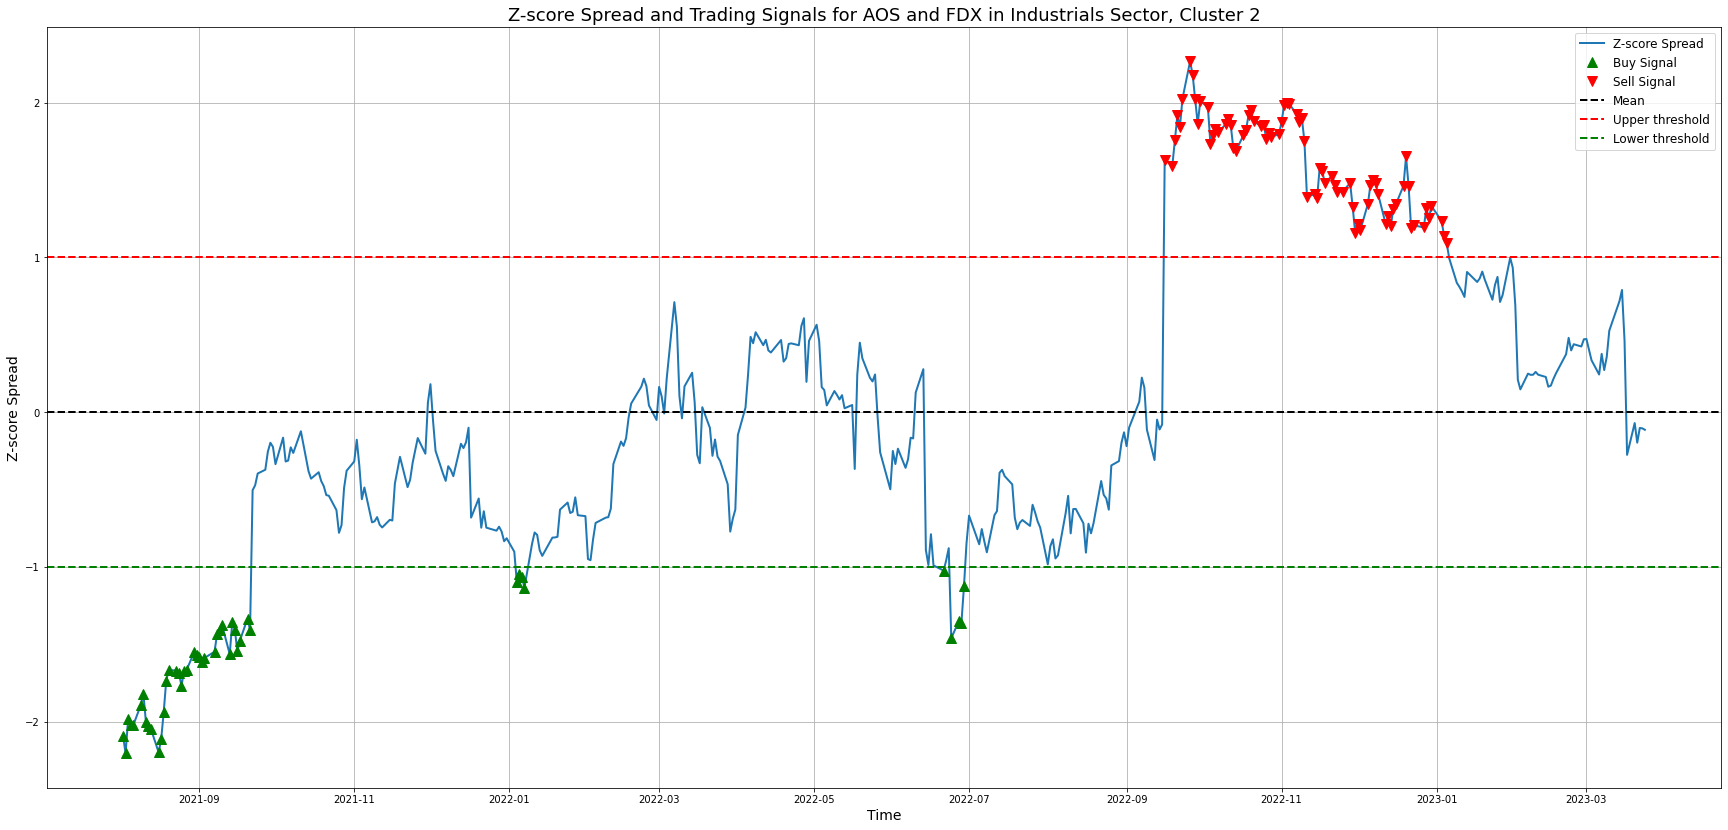

        Date Action     Price          Cash
0 2021-08-02    Buy -2.090696  10002.090696
1 2022-09-16   Sell  1.632051  10003.722747
2 2022-09-19   Sell  1.591572  10005.314319


In [18]:
#I WORKED HERE WITH THE Industrials AS AN EXEMPLE SINON IL VA PRENDRE VALEUR DIAL SECTOR GIVEN BY THE USER
sector = 'Industrials'

"""
the use of function 1
"""
selected_pairs1 = analyze_cluster_pairs(sector, 1, 0.1, 0.1)  # Replace sector with the actual sector name and adjust significance levels as needed
#print("Selected pairs for mean reversion trading cluster 1:", selected_pairs1)


"""
the use of function 2
"""

selected_pairs = analyze_cluster_pairs(sector, 2)

pair=selected_pairs[0]
upper_threshold = 1
lower_threshold = -1
initial_cash = 10000

trade_history = plot_and_simulate_trading(pair, sector, cluster_num, upper_threshold, lower_threshold, initial_cash)
print(trade_history)

Step 3 : 